In [1]:
import torch; torch.manual_seed(0)
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

path_Confocal = f'./datasets/Confocal/'
path_STED = f'./datasets/STED'
path_STED_HC = f'./datasets/STED_HC/'

BATCH_SIZE = 128
EPOCHS = 2000
LATENTDIM = 256 #32-64-128

model = f'./models/vae_model_{EPOCHS}epo_{BATCH_SIZE}bth_{LATENTDIM}latn.pth'
print(model)

./models/vae_model_2000epo_128bth_256latn.pth


In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 32 * 32, latent_dim) 
        self.fc_logvar = nn.Linear(64 * 32 * 32, latent_dim) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 32 * 32)
        self.conv3 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(16, 4, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.conv1 = nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1, output_padding=0)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 32, 32)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 指定使用 CPU 设备
vae = VAE(LATENTDIM)  # 根据您的模型定义创建一个 VAE 实例
vae.to(device)
vae = nn.DataParallel(vae)
vae.load_state_dict(torch.load(model, map_location=device))  # 加载模型参数并将其移到 CPU
vae.eval()  # 设置模型为评估模式

DataParallel(
  (module): VAE(
    (encoder): Encoder(
      (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (fc_mu): Linear(in_features=65536, out_features=256, bias=True)
      (fc_logvar): Linear(in_features=65536, out_features=256, bias=True)
    )
    (decoder): Decoder(
      (fc): Linear(in_features=256, out_features=65536, bias=True)
      (conv3): ConvTranspose2d(64, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): ConvTranspose2d(16, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv1): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
)

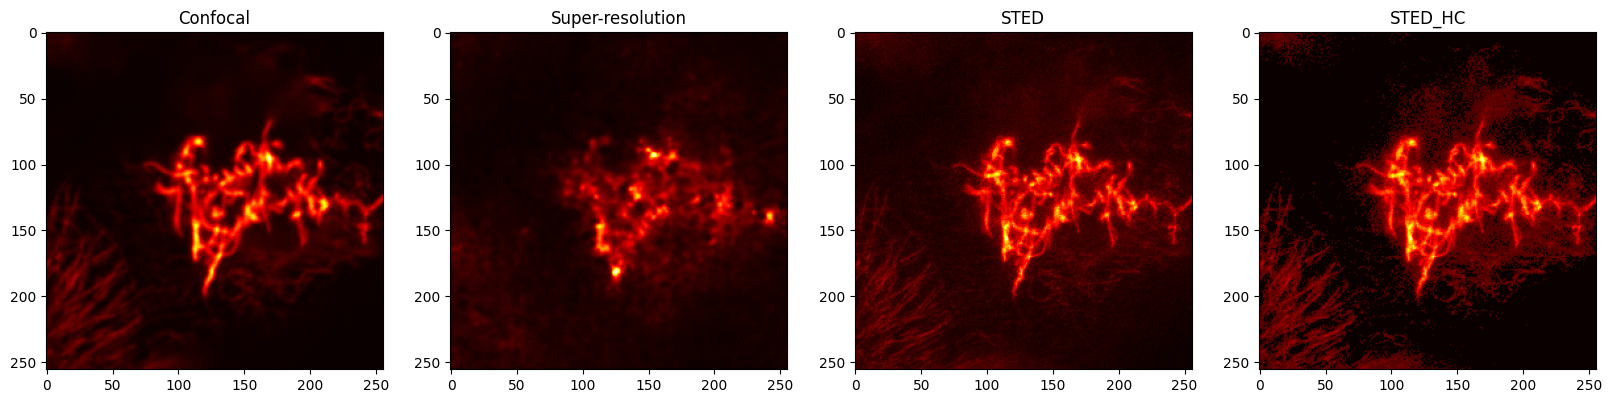

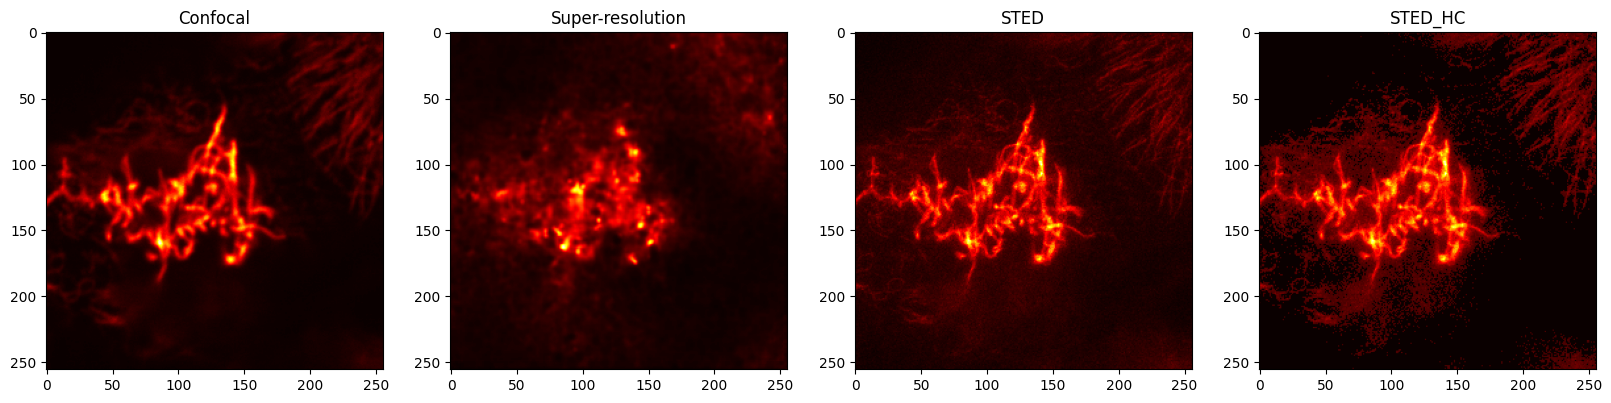

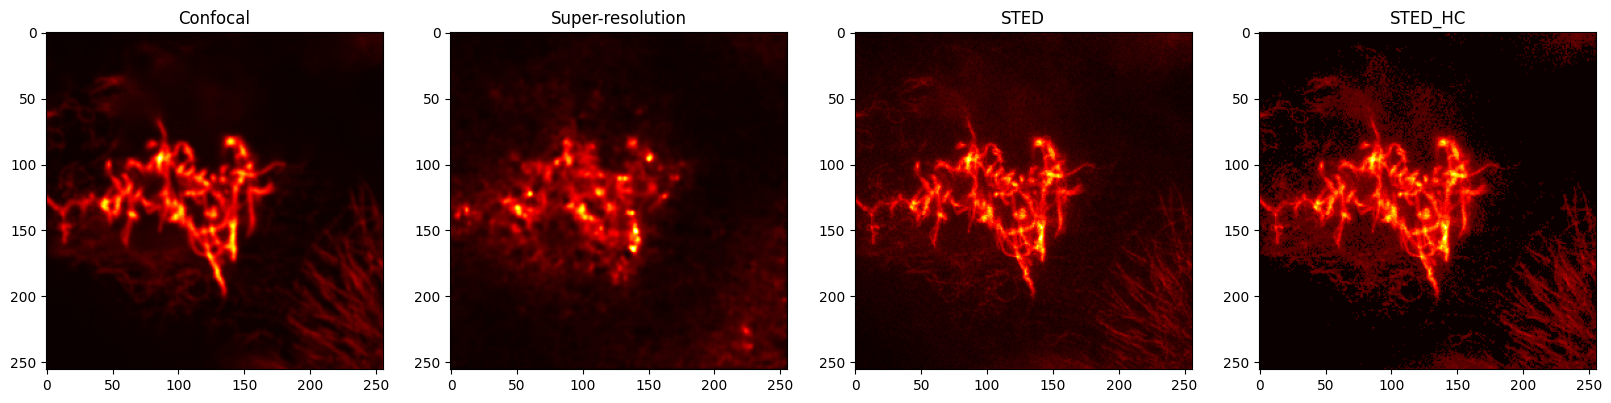

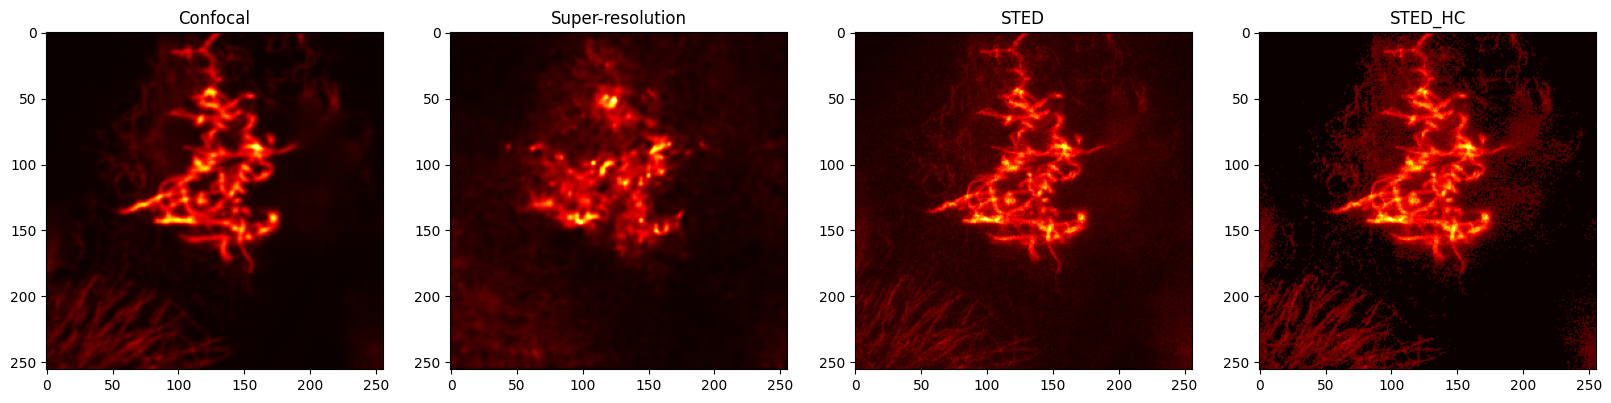

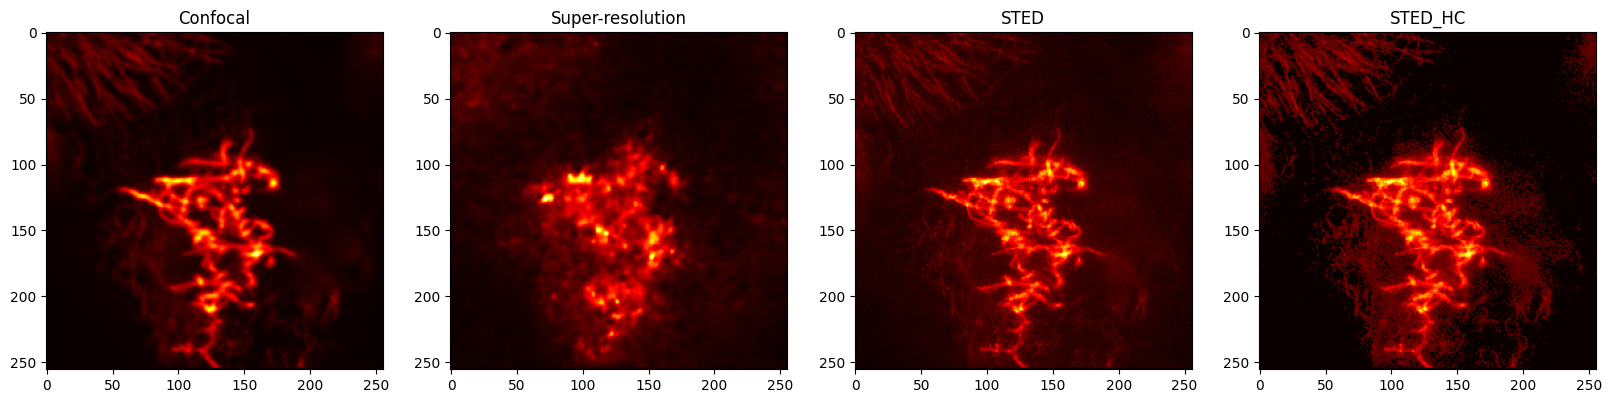

In [6]:
first_fig_num = 5233
iteration_times = 1
do_save = 1
for i in range(first_fig_num,first_fig_num+5):
    img_Confocal = Image.open(f"{path_Confocal}/{i}_Confocal.png").convert('L')
    img_STED = Image.open(f"{path_STED}/{i}_STED.png").convert('L')
    img_STED_HC = Image.open(f"{path_STED_HC}/{i}_STED_HC.png").convert('L')
    preprocess = transforms.Compose([transforms.ToTensor()])
    
    img_tobe_iterated = img_Confocal
    for j in range(iteration_times):
        img_tobe_iterated= preprocess(img_tobe_iterated)
        img_tobe_iterated = img_tobe_iterated.unsqueeze(0).to(device)  # 添加批次维度，变为 shape [1, C, H, W]
        with torch.no_grad():
            img_tobe_iterated = vae(img_tobe_iterated)
        img_tobe_iterated = img_tobe_iterated[0][0].squeeze(0)
        img_tobe_iterated = img_tobe_iterated.to('cpu')
        img_tobe_iterated = img_tobe_iterated.numpy()
        img_tobe_iterated = (img_tobe_iterated - img_tobe_iterated.min()) / (img_tobe_iterated.max() - img_tobe_iterated.min()) * 255.0
        img_tobe_iterated = img_tobe_iterated.astype(np.uint8)
        img_tobe_iterated = Image.fromarray(img_tobe_iterated)
    img_SR = img_tobe_iterated
    #loss = mse(img_SR,img_STED_HC) + 1 - ssim(img_SR,img_STED_HC_np)
    fig,ax = plt.subplots(1,4)
    plt.rcParams['figure.figsize'] = [20, 10]
    ax[0].imshow(img_Confocal,cmap='hot')
    ax[0].set_title('Confocal')
    ax[1].imshow(img_SR,cmap='hot')
    
    ax[1].set_title('Super-resolution')
    ax[2].imshow(img_STED,cmap='hot')
    
    ax[2].set_title('STED')
    ax[3].imshow(img_STED_HC,cmap='hot')
    
    ax[3].set_title('STED_HC')
    #plt.savefig('1.png')
    plt.show()
    if do_save == 1:
        img_Confocal.save(f'./imgs/{i}_Confocal.png')
        img_SR.save(f'./imgs/{i}_SR.png')
        img_STED.save(f'./imgs/{i}_STED.png')
        img_STED_HC.save(f'./imgs/{i}_STED_HC.png')
    # print(f'loss为{loss}')